# Выявления мошейничества с кредитами

In [82]:
%matplotlib inline
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [18]:
df = pd.read_csv('creditcard.csv')

# Рассматриваем признаки датасета

In [23]:
print('Количество строк в датасете: {}, количество столбцов: {}'.format(df.shape[0], df.shape[1]))

Количество строк в датасете: 284807, количество столбцов: 31


In [24]:
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
148024,89280.0,-0.912909,-0.392871,1.022011,-0.782771,0.678028,-0.438318,0.276363,0.200120,0.540020,...,0.403577,1.024797,-0.090497,-0.327602,-0.061994,-0.270324,0.127779,0.177814,70.92,0
23563,32822.0,-0.168375,0.195786,1.229898,-0.971330,-0.325359,-0.731535,0.550592,-0.329503,-1.656448,...,-0.676660,-1.462213,0.241494,0.283724,-1.042878,0.564109,-0.213701,-0.086135,21.89,0
233389,147545.0,-0.477104,-0.219560,0.658412,-0.121073,0.714301,0.070826,-0.275029,0.380856,0.639453,...,0.329914,1.046690,-0.067474,0.685603,-0.244210,0.658745,0.055967,0.096790,34.10,0
107869,70656.0,-0.095647,-1.247059,2.716902,-1.673317,-2.076914,0.923397,-1.997243,-0.337650,-0.454682,...,0.479153,-0.383743,-0.458208,0.096836,1.316708,0.020926,0.172879,0.152812,35.50,0
189217,128308.0,0.012376,0.663165,-0.781750,-0.935760,1.647444,1.224445,0.487815,0.615472,0.045336,...,-0.271364,-0.667823,0.124539,-1.106558,-0.656981,0.231026,0.252829,0.053042,5.49,0


In [26]:
pd.set_option('precision', 3)
df.loc[:, ['Time', 'Amount']].describe()

,Time,Amount
count,284807.000,284807.000
mean,94813.860,88.350
std,47488.146,250.120
min,0.000,0.000
25%,54201.500,5.600
50%,84692.000,22.000
75%,139320.500,77.165
max,172792.000,25691.160


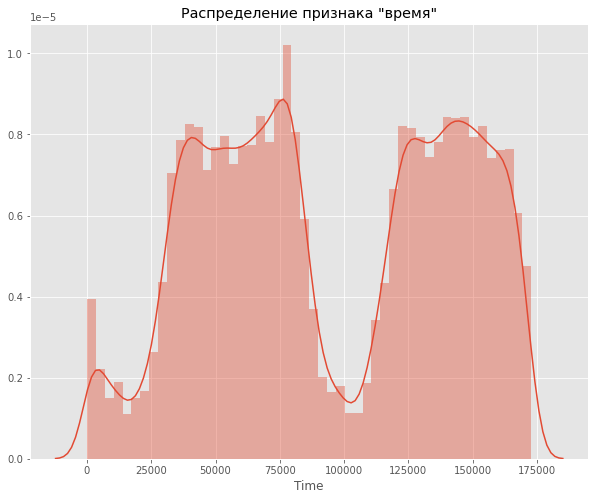

In [29]:
plt.figure(figsize=(10,8))
plt.title('Распределение признака "время"')
sns.distplot(df.Time)

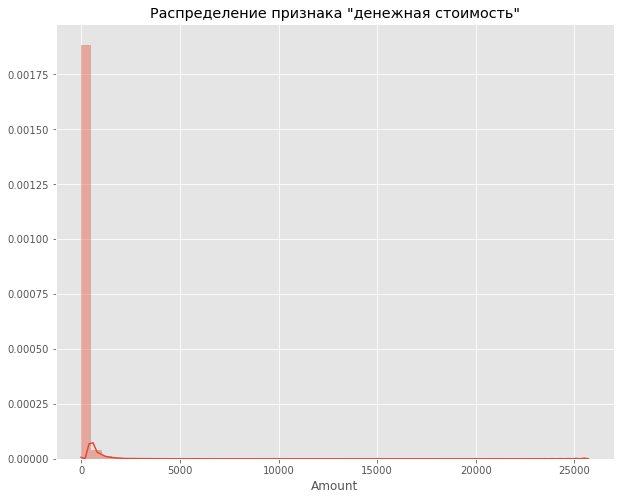

In [30]:
plt.figure(figsize=(10,8))
plt.title('Распределение признака "денежная стоимость"')
sns.distplot(df.Amount)

Средняя сумма транзакции в датасете - около 88 долларов

Максимальная сумма транзакции - около 25,691 долларов

In [33]:
counts = df.Class.value_counts()
normal = counts[0]
fraudulent = counts[1]
perc_normal = (normal/(normal+fraudulent))*100
perc_fraudulent = (fraudulent/(normal+fraudulent))*100
print('В датасете {} нормальных транзакций ({:.3f}%) и {} мошейнеческих транзакций ({:.3f}%).'.format(normal, perc_normal, fraudulent, perc_fraudulent))

В датасете 284315 нормальных транзакций (99.827%) и 492 мошейнеческих транзакций (0.173%).


Text(0.5, 1.0, 'Находим корреляции признаков попарно')

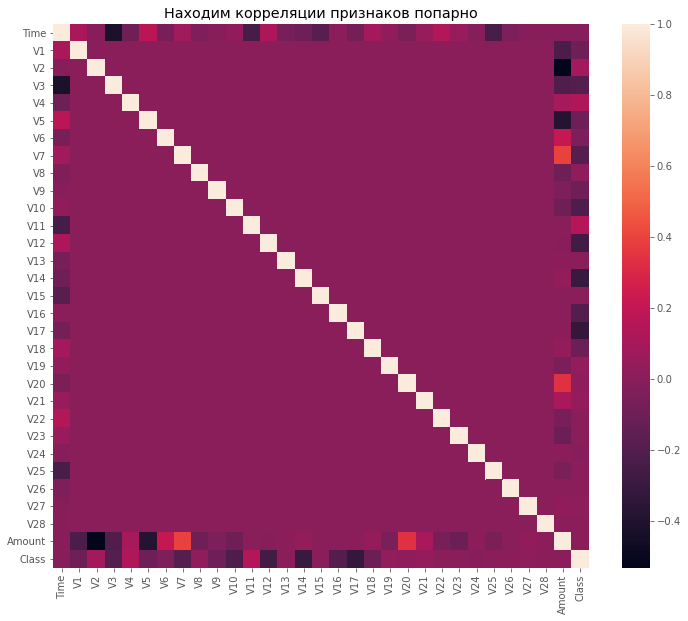

In [37]:
corr = df.corr()
plt.figure(figsize=(12,10))
heat = sns.heatmap(data=corr)
plt.title('Находим корреляции признаков попарно')

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler2 = StandardScaler()
#scaling time
scaled_time = scaler.fit_transform(df[['Time']])
flat_list1 = [item for sublist in scaled_time.tolist() for item in sublist]
scaled_time = pd.Series(flat_list1)

In [39]:
scaled_amount = scaler2.fit_transform(df[['Amount']])
flat_list2 = [item for sublist in scaled_amount.tolist() for item in sublist]
scaled_amount = pd.Series(flat_list2)

# Разбиение датасета на тренировочную и тестовую выборку

In [40]:
df = pd.concat([df, scaled_amount.rename('scaled_amount'), scaled_time.rename('scaled_time')], axis=1)
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_amount,scaled_time
85647,60867.0,-0.412,0.220,1.619,-2.236,-0.024,-0.994,0.690,-0.528,1.019,...,-0.178,0.352,-0.584,-0.346,-0.445,-0.284,3.92,0,-0.338,-0.715
151107,94630.0,-5.517,4.882,-4.786,-0.889,-2.429,-0.660,-2.883,4.291,1.234,...,0.488,-1.502,0.306,0.217,-0.226,-0.027,8.98,0,-0.317,-0.004
87874,61886.0,1.252,-0.523,-0.093,-0.626,-0.558,-0.330,-0.564,-0.052,-0.775,...,-0.104,-0.522,0.354,-0.229,0.035,0.050,79.90,0,-0.034,-0.693
271828,164769.0,1.818,-0.100,-1.191,2.761,2.164,4.773,-1.162,1.219,-0.411,...,0.175,0.690,-0.155,0.106,0.033,-0.035,23.14,0,-0.261,1.473
63728,50846.0,-0.594,1.186,0.928,0.821,-0.258,-0.500,0.319,0.463,-0.929,...,-0.089,0.315,-0.297,-0.347,0.034,0.090,18.00,0,-0.281,-0.926


In [41]:
df.drop(['Amount', 'Time'], axis=1, inplace=True)

In [44]:
mask = np.random.rand(len(df)) < 0.9
train = df[mask]
test = df[~mask]
print('Размеры тренировочной выборки выборки: {}\nРазмеры тестовой выбоки: {}'.format(train.shape, test.shape))

Размеры тренировочной выборки выборки: (256342, 31)
Размеры тестовой выбоки: (28465, 31)


In [46]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Создание подвыборки датасета со сбалансированными распределениями классов

In [48]:
no_of_frauds = train.Class.value_counts()[1]
print('В тренировочной выборке {} мошейнических транзакций'.format(no_of_frauds))

В тренировочной выборке 441 мошейнических транзакций


In [49]:
non_fraud = train[train['Class'] == 0]
fraud = train[train['Class'] == 1]

In [50]:
selected = non_fraud.sample(no_of_frauds)
selected.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
218822,0.628,-2.580,-4.042,0.396,0.786,-0.045,1.879,-0.547,-0.308,0.029,...,0.248,-1.043,-0.553,0.477,0.967,-0.316,0.028,0,2.960,1.201
122751,-0.933,-0.243,1.939,-1.020,-1.759,-0.318,-0.550,0.445,-1.182,-0.174,...,0.399,0.280,0.433,-0.673,1.023,-0.031,0.067,0,0.150,-0.276
32622,1.148,0.596,0.106,2.392,0.185,-0.530,0.448,-0.107,-1.223,0.915,...,-0.011,-0.127,0.312,0.672,0.051,-0.051,0.002,0,-0.262,-1.187
30371,1.488,-1.005,0.649,-1.187,-1.915,-1.367,-0.982,-0.218,-1.703,1.477,...,-0.219,0.118,0.862,0.278,-0.235,0.024,0.023,0,-0.313,-1.210
102373,-1.095,0.236,0.995,1.429,-1.464,1.199,-1.154,1.236,0.476,-0.498,...,0.785,-0.208,-0.385,-0.424,0.756,-0.106,-0.184,0,0.077,-0.455


In [51]:
selected.reset_index(drop=True, inplace=True)
fraud.reset_index(drop=True, inplace=True)

In [52]:
subsample = pd.concat([selected, fraud])
len(subsample)

882

In [53]:
subsample = subsample.sample(frac=1).reset_index(drop=True)
subsample.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.101,-1.675,-0.573,5.618,0.766,0.441,1.935,-1.020,-0.193,1.784,...,-0.209,0.345,1.091,-0.687,0.076,0.034,-0.833,1,2.186,0.333
1,1.037,0.407,0.758,3.162,-0.568,0.202,-0.690,0.411,0.337,-0.284,...,0.124,-0.133,0.350,0.508,0.190,0.061,0.063,1,-0.350,-0.882
2,-0.684,1.237,-0.455,-0.791,0.382,-0.505,0.617,-0.801,0.267,-0.129,...,-0.999,0.128,-0.750,-0.409,0.143,-0.260,-0.201,0,-0.233,1.523
3,-2.945,2.669,-0.352,-1.721,-0.599,1.679,-2.137,-6.696,-0.392,-0.920,...,-1.587,0.815,-0.893,-0.255,0.747,0.367,0.139,0,-0.033,-0.840
4,1.190,0.942,0.082,3.024,0.412,-0.214,0.054,-0.110,0.884,-0.554,...,-1.047,-0.057,-0.341,0.541,-0.098,-0.003,0.050,1,-0.338,-1.634
5,-0.670,0.945,0.610,2.640,-2.708,1.953,-1.625,-5.230,0.210,-2.070,...,1.436,0.352,0.648,0.580,0.076,0.347,0.282,1,0.941,-0.178
6,-7.030,3.422,-9.525,5.271,-4.025,-2.866,-6.989,3.792,-4.623,-8.410,...,-0.542,0.037,-0.356,0.354,1.042,1.360,-0.272,1,-0.353,-0.201
7,-1.278,0.716,-1.143,0.218,-1.294,-1.169,-2.564,0.205,-1.611,-1.250,...,0.470,-0.126,-0.127,-0.662,-0.350,0.455,0.138,1,-0.254,-1.081
8,2.302,-0.636,-1.747,-1.168,0.067,-0.526,-0.373,-0.293,-0.573,0.857,...,1.159,-0.053,0.098,0.324,0.081,-0.036,-0.067,0,-0.349,1.494
9,-1.307,-0.743,-4.337,-0.147,0.045,1.603,3.709,0.399,-1.121,-2.195,...,0.423,1.895,-1.264,-0.120,0.595,-0.144,0.087,0,2.974,0.819


Text(0.5, 0, 'Класс (0 : Нормальные, 1 : Мошейнические)')

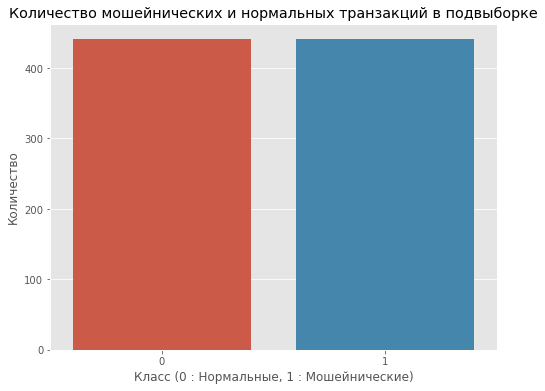

In [57]:
new_counts = subsample.Class.value_counts()
plt.figure(figsize=(8,6))
sns.barplot(x=new_counts.index, y=new_counts)
plt.title('Количество мошейнических и нормальных транзакций в подвыборке')
plt.ylabel('Количество')
plt.xlabel('Класс (0 : Нормальные, 1 : Мошейнические)')

In [55]:
corr = subsample.corr()
corr = corr[['Class']]
corr

,Class
V1,-0.432
V2,0.500
V3,-0.567
V4,0.712
V5,-0.376
V6,-0.415
V7,-0.476
V8,0.065
V9,-0.553
V10,-0.629


In [58]:
corr[corr.Class < -0.5]

,Class
V3,-0.567
V9,-0.553
V10,-0.629
V12,-0.684
V14,-0.751
V16,-0.601
V17,-0.566


In [59]:
corr[corr.Class > 0.5]

,Class
V4,0.712
V11,0.687
Class,1.000


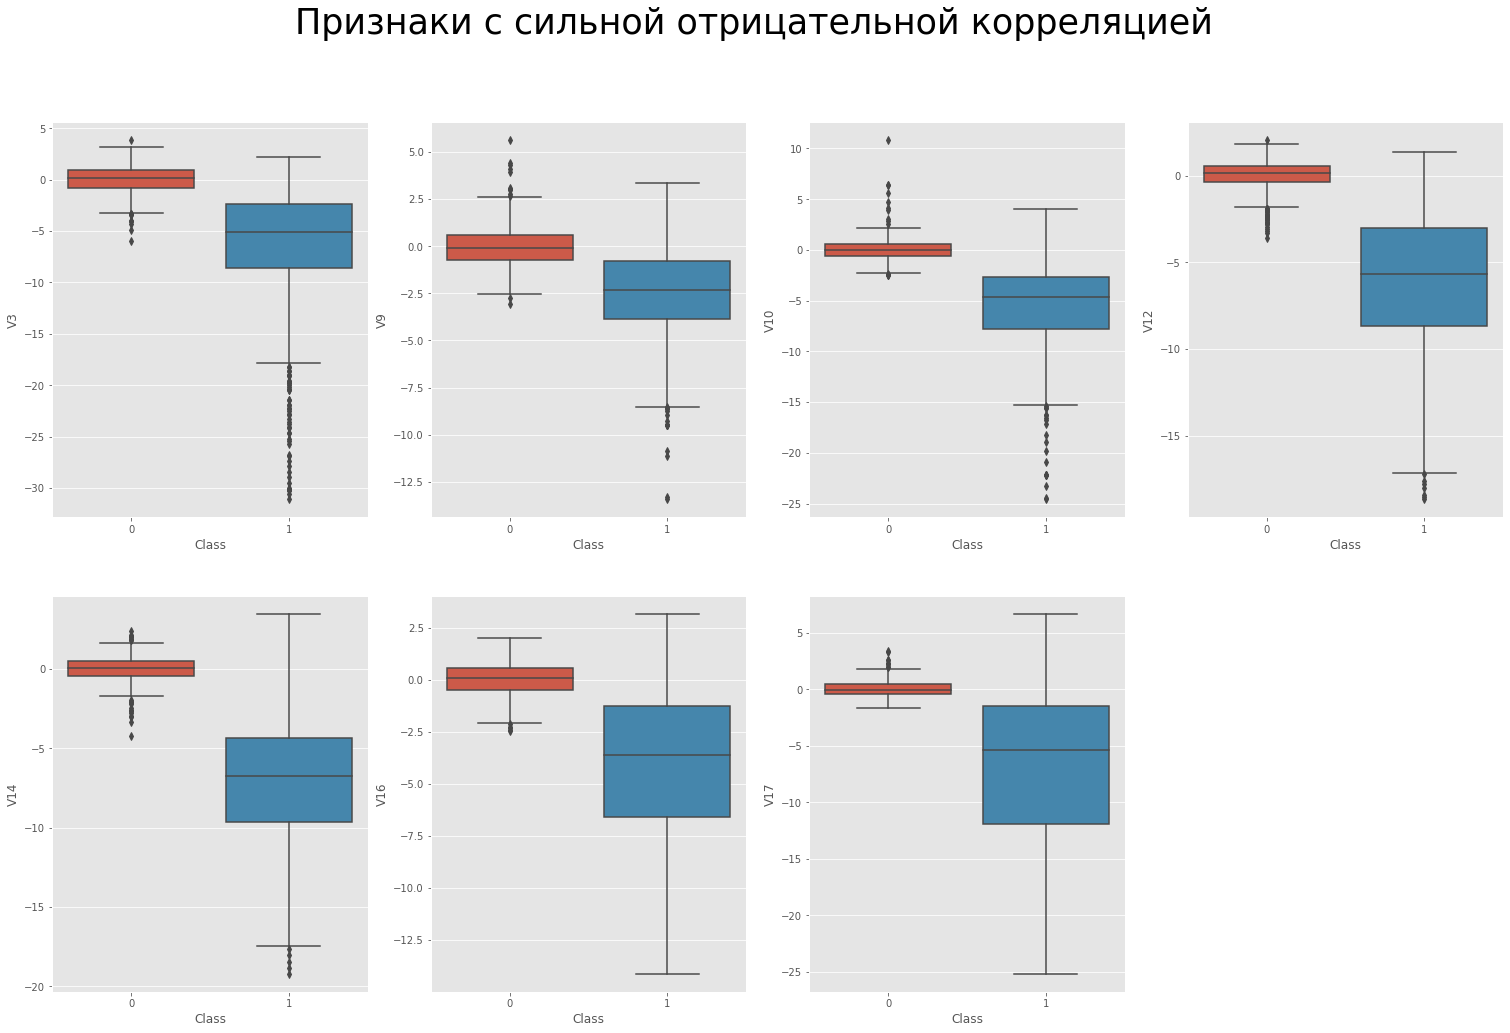

In [62]:
#visualizing the features w high negative correlation
f, axes = plt.subplots(nrows=2, ncols=4, figsize=(26,16))

f.suptitle('Признаки с сильной отрицательной корреляцией', size=35)
sns.boxplot(x="Class", y="V3", data=subsample, ax=axes[0,0])
sns.boxplot(x="Class", y="V9", data=subsample, ax=axes[0,1])
sns.boxplot(x="Class", y="V10", data=subsample, ax=axes[0,2])
sns.boxplot(x="Class", y="V12", data=subsample, ax=axes[0,3])
sns.boxplot(x="Class", y="V14", data=subsample, ax=axes[1,0])
sns.boxplot(x="Class", y="V16", data=subsample, ax=axes[1,1])
sns.boxplot(x="Class", y="V17", data=subsample, ax=axes[1,2])
f.delaxes(axes[1,3])

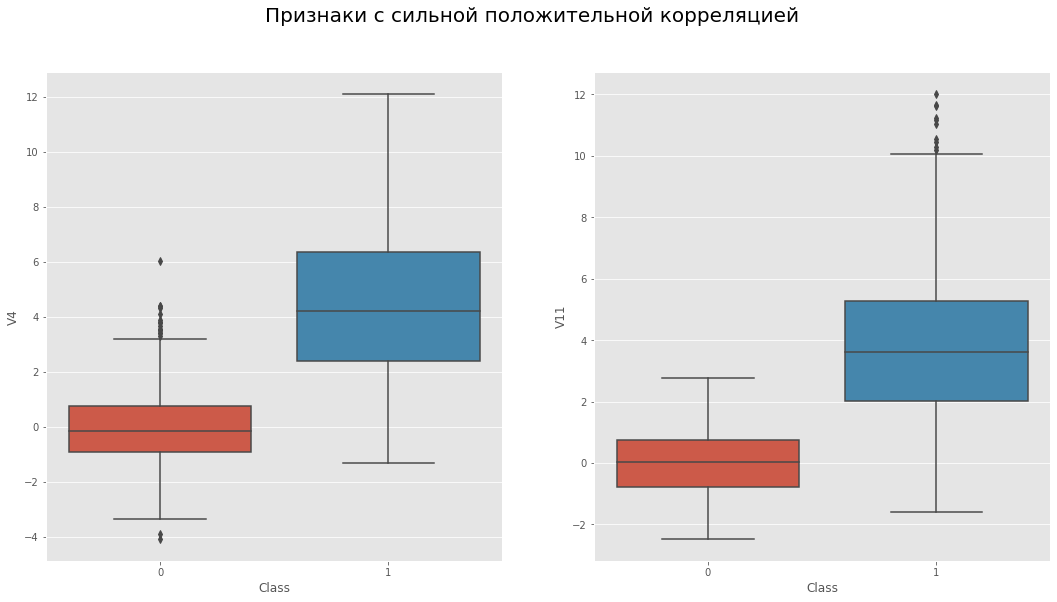

In [63]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,9))

f.suptitle('Признаки с сильной положительной корреляцией', size=20)
sns.boxplot(x="Class", y="V4", data=subsample, ax=axes[0])
sns.boxplot(x="Class", y="V11", data=subsample, ax=axes[1])

# Удаление выбросов

In [64]:
Q1 = subsample.quantile(0.25)
Q3 = subsample.quantile(0.75)
IQR = Q3 - Q1

df2 = subsample[~((subsample < (Q1 - 2.5 * IQR)) |(subsample > (Q3 + 2.5 * IQR))).any(axis=1)]

In [66]:
len_after = len(df2)
len_before = len(subsample)
len_difference = len(subsample) - len(df2)
print('Размер данных уменьшился с {} на {} до {} транзакций'.format(len_before, len_difference, len_after))

Размер данных уменьшился с 882 на 256 до 626 транзакций


# Уменьшение размерности

In [67]:
from sklearn.manifold import TSNE

X = df2.drop('Class', axis=1)
y = df2['Class']

In [68]:
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

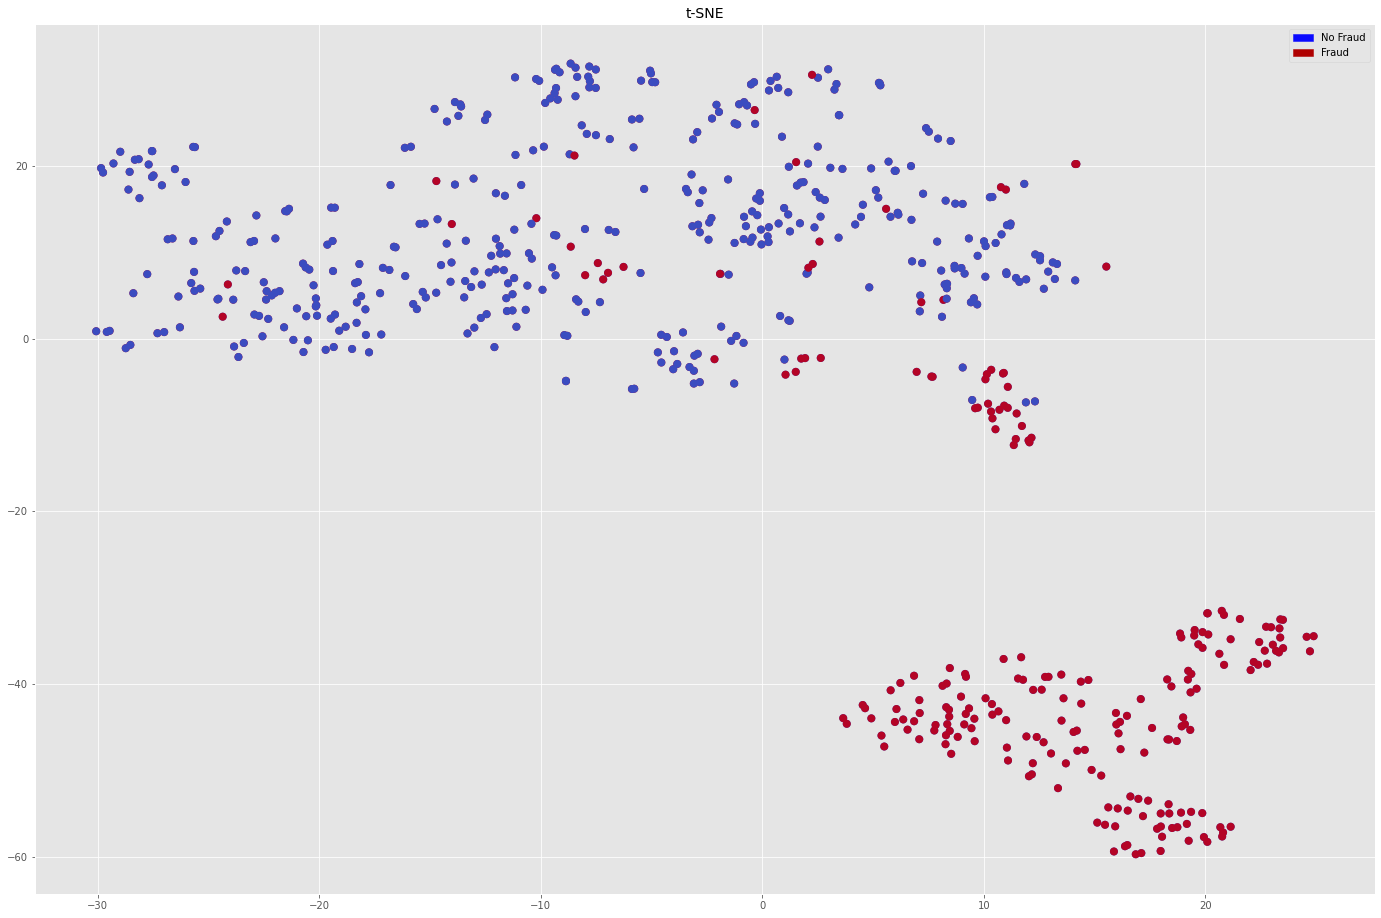

In [69]:
import matplotlib.patches as mpatches

f, ax = plt.subplots(figsize=(24,16))


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax.set_title('t-SNE', fontsize=14)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])

# Классификация

In [70]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
X_train = X_train.values
X_validation = X_test.values
y_train = y_train.values
y_validation = y_test.values

In [73]:
print('X_shapes:\n', 'X_train:', 'X_validation:\n', X_train.shape, X_validation.shape, '\n')
print('Y_shapes:\n', 'Y_train:', 'Y_validation:\n', y_train.shape, y_validation.shape)

X_shapes:
 X_train: X_validation:
 (500, 30) (126, 30) 

Y_shapes:
 Y_train: Y_validation:
 (500,) (126,)


In [75]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [77]:
models = []

models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))

#testing models

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.979646 (0.016998)
LDA: 0.970821 (0.024540)
KNN: 0.955484 (0.028079)
CART: 0.910186 (0.033088)
SVM: 0.975191 (0.022245)
RF: 0.969655 (0.018329)


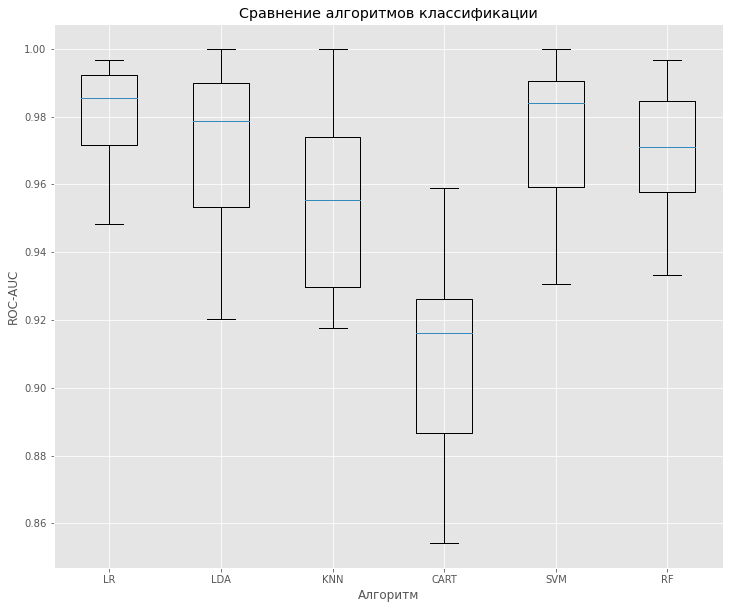

In [81]:
fig = plt.figure(figsize=(12,10))
plt.title('Сравнение алгоритмов классификации')
plt.xlabel('Алгоритм')
plt.ylabel('ROC-AUC')
plt.boxplot(results)
ax = fig.add_subplot(111)
ax.set_xticklabels(names)
plt.show()

Таким образом, на данном датасете алгоритм линейной регрессии показал наилучшие результаты